In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
            
            if mode == "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
            elif mode == "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, mode=mode, scaled=scale, bias=bias, 
                              stype=stype, btype=btype, rtype=rtype).to(device)

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device)
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, rtype=rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype=stype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 0.26973605155944824 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010500218719244003 max: -0.0013098465278744698 RMSE:  0.006282774731516838
error distribution=========>


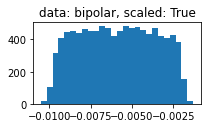

progressive accuracy=========>


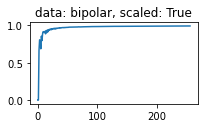

--- 0.26205921173095703 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.242828369140625 max: 0.1171875 RMSE:  0.3046656548976898
error distribution=========>


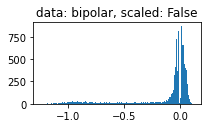

progressive accuracy=========>


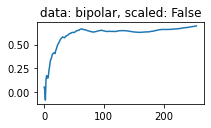

--- 0.16403698921203613 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.00566217303276062 max: -0.0013722479343414307 RMSE:  0.0037130399141460657
error distribution=========>


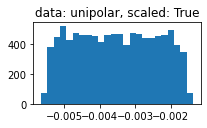

progressive accuracy=========>


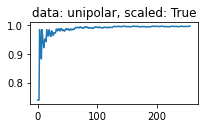

--- 0.15703558921813965 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


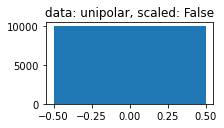

progressive accuracy=========>


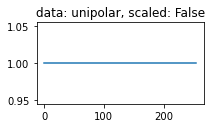

In [5]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.26405954360961914 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010316220112144947 max: -0.0011741835623979568 RMSE:  0.006168846972286701
error distribution=========>


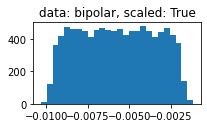

progressive accuracy=========>


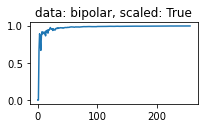

--- 0.2600586414337158 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -1.3159637451171875 max: 0.3671875 RMSE:  0.32387158274650574
error distribution=========>


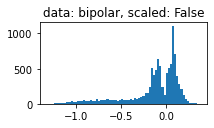

progressive accuracy=========>


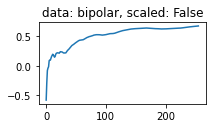

--- 0.1670379638671875 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.006541207432746887 max: -0.0022426247596740723 RMSE:  0.00453209737315774
error distribution=========>


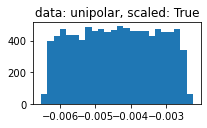

progressive accuracy=========>


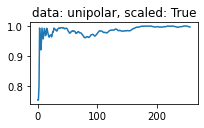

--- 0.16803765296936035 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


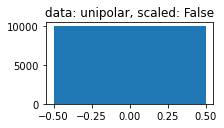

progressive accuracy=========>


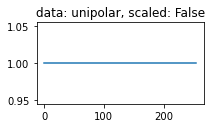

In [6]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.2780625820159912 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010651765391230583 max: -0.0016234694048762321 RMSE:  0.0065282732248306274
error distribution=========>


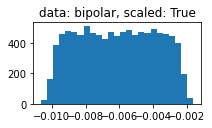

progressive accuracy=========>


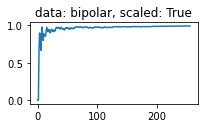

--- 0.27506160736083984 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.8828125 max: 1.6796875 RMSE:  0.5562850832939148
error distribution=========>


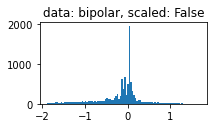

progressive accuracy=========>


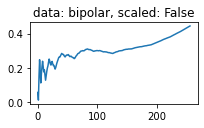

--- 0.1800401210784912 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005551055073738098 max: -0.0012254714965820312 RMSE:  0.00356721761636436
error distribution=========>


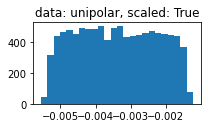

progressive accuracy=========>


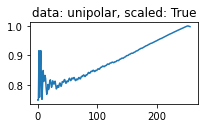

--- 0.16203618049621582 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


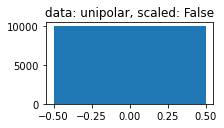

progressive accuracy=========>


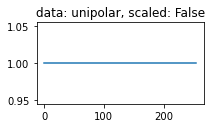

In [7]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.2740612030029297 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010826274752616882 max: -0.0016583893448114395 RMSE:  0.006667473819106817
error distribution=========>


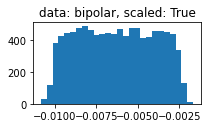

progressive accuracy=========>


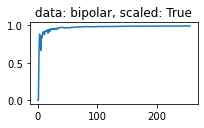

--- 0.25905823707580566 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.359375 max: 0.2391510009765625 RMSE:  0.318011611700058
error distribution=========>


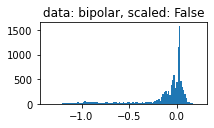

progressive accuracy=========>


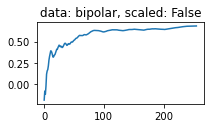

--- 0.17003798484802246 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005584090948104858 max: -0.001261398196220398 RMSE:  0.0036019226536154747
error distribution=========>


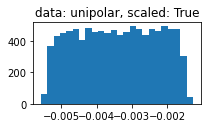

progressive accuracy=========>


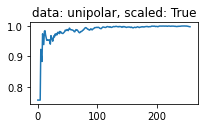

--- 0.17103838920593262 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


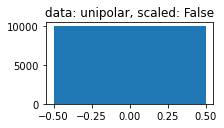

progressive accuracy=========>


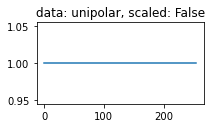

In [8]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)